In [104]:
%matplotlib inline

import numpy as np
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestClassifier

mpl.rc('font', family='serif', size=16)

## Simulate 2D data for anomaly detection

This simulation only considers two feature axis, next step is increase to a 10-D featureset corresponding to a spectrum with 10 flux values.

In [2]:
mean = [50, 60]
cov  = [[5,5], [100,200]]
x1, y1 = np.random.multivariate_normal(mean, cov, 1000).T

mean = [65, 70]
cov  = [[20,10], [2,10]]
x2, y2 = np.random.multivariate_normal(mean, cov, 1000).T

# and additional noises
mean = [60, 60]
cov  = [[100, 0], [0, 100]]
x3, y3 = np.random.multivariate_normal(mean, cov, 200).T

/Users/ryanrubenzahl/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:3: RuntimeWarning: covariance is not positive-semidefinite.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ryanrubenzahl/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:7: RuntimeWarning: covariance is not positive-semidefinite.
  import sys


In [5]:
# Concatenate to single vector
x_total = np.concatenate((x1, x2, x3))
y_total = np.concatenate((y1, y2, y3))
X = np.array([x_total, y_total]).T

# Create object IDs (integers)
obj_ids = np.arange(len(x_total))

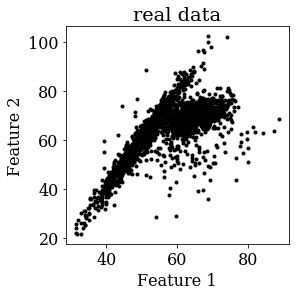

In [236]:
fig, ax = plt.subplots(1,1, figsize=(4,4))

ax.plot(X[:, 0], X[:, 1], "ok", markersize=3)
ax.set(xlabel='Feature 1', ylabel='Feature 2', title='real data')

## Outlier detection algorithm

Detect outling objects in the 2D data given above (the 'real' data).

**Step 1:** Create 'synthetic' data with the same sample size as the 'real' data, and the same marginal distributions in its features.

**Step 2:** Label the 'real' data as Class I and the 'synthetic' data as Class II. Merge the two samples with their labels into a data matrix **X** and label vector **Y**.

**Step 3:** Train the Random Forest to distinguish between Class I and Class II.

**Step 4:** Once we have the trained forest, we propogate the 'real'data through the RF to obtain a pair-wise distance for all the objects in our sample.

**Step 5:** Sum the distances from a given object to all the rest to obtain the final weirdness score.

**Step 6:** Sort the weirdness score vector and extract the N weirdest objects in the sample.

### Step 1
Create synthetic data and plot it along with our real data

In [8]:
def return_synthetic_data(X):
    """
    Return a matrix with the same dimensions as X containing synthetic 
    data based on the marginal distribution of the features in X
    """
    features = len(X[0])
    X_syn = np.zeros(X.shape)
    
    for i in xrange(features):
        obs_vec = X[:, i]
        # Make synthetic data match marginal distribution of real data
        syn_vec = np.random.choice(obs_vec, len(obs_vec))
        X_syn[:, i] += syn_vec
        
    return X_syn

X_syn = return_synthetic_data(X)

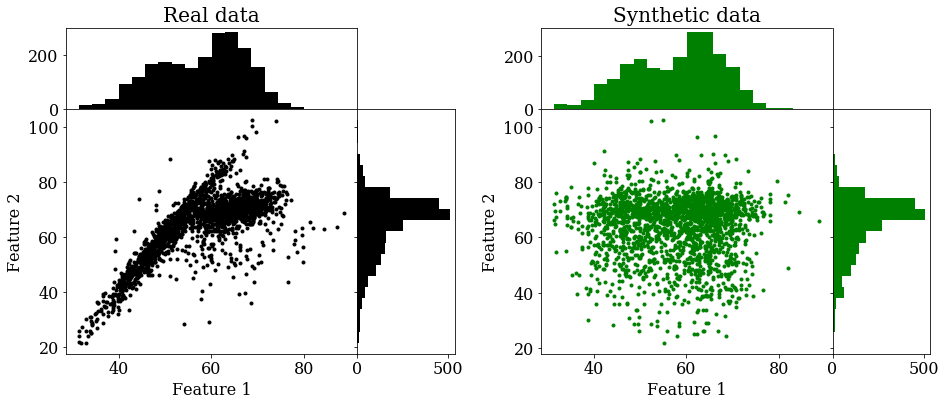

In [97]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(12,6))

# Real data
gs1 = GridSpec(2,2,height_ratios=[1,3], width_ratios=[3,1])
gs1.update(left=0.0, right=0.45, hspace=0.0, wspace=0.0)
ax1 = plt.subplot(gs1[0,0])
ax2 = plt.subplot(gs1[1,0])
ax3 = plt.subplot(gs1[1,1])

ax1.set_title('Real data', size=20)
ax2.set(xlabel='Feature 1', ylabel='Feature 2')
ax2.plot(X[:, 0], X[:, 1], "ok", markersize=3)
ax1.hist(X[:, 0], bins=20, color='k')
ax3.hist(X[:, 1], bins=20, color='k', orientation='horizontal')
ax2.get_shared_x_axes().join(ax2, ax1)
ax2.get_shared_y_axes().join(ax2, ax3)
ax1.set_xticklabels([])
ax3.set_yticklabels([])

# Synthetic data
gs2 = GridSpec(2,2,height_ratios=[1,3], width_ratios=[3,1])
gs2.update(left=0.55, right=1., hspace=0.0, wspace=0.0)
ax5 = plt.subplot(gs2[0,0])
ax6 = plt.subplot(gs2[1,0])
ax7 = plt.subplot(gs2[1,1])

ax5.set_title('Synthetic data', size=20)
ax6.set(xlabel='Feature 1', ylabel='Feature 2')
ax6.plot(X_syn[:, 0], X_syn[:, 1], "og", markersize=3)
ax5.hist(X_syn[:, 0], bins=20, color='g')
ax7.hist(X_syn[:, 1], bins=20, color='g', orientation='horizontal')
ax6.get_shared_x_axes().join(ax6, ax5)
ax6.get_shared_y_axes().join(ax6, ax7)
ax5.set_xticklabels([])
ax7.set_yticklabels([])

# Also have the left and right plots share axis
ax2.get_shared_x_axes().join(ax2, ax5)
ax2.get_shared_y_axes().join(ax2, ax5)

print

### Step 2
Merge synthetic data with real data into a single sample, and assign classes to each entry ('real' or 'synthetic'). Then train an RF to distinguish between these two classes.

The RF is trained on the entire dataset, that is without dividing it into 'training', 'testing', and 'validation' subsets. This is because we are not (currently) looking to apply the RF to new data, but rather learn what outliers look like in our current data.

In [98]:
def merge_real_and_synthetic_samples(X, X_syn):
    """
    The function merges the data into one sample, giving 
    the label "1" to real data and "2" to synthetic data
    """
    # Build labels vector
    real_labels = np.ones(len(X))
    syn_labels  = np.ones(len(X_syn)) * 2
    
    # Merge real/synthetic labels and real/synthetic data
    labels_total = np.concatenate((real_labels, syn_labels))
    X_total      = np.concatenate((X, X_syn))
    
    return X_total, labels_total

In [105]:
X_total, labels_total = merge_real_and_synthetic_samples(X, X_syn)

# Declare Random Forest
N_TRAIN = 500 # Numer of trees in the forest
RF = RandomForestClassifier(n_estimators=N_TRAIN)
RF.fit(X_total, labels_total)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [137]:
# Now plot the probability of an object to be classified as 'real'

x, y = np.meshgrid(np.linspace(0, 140, 100), np.linspace(0, 140, 1000))
z = RF.predict_proba(np.c_[x.ravel(), y.ravel()])[:, 0] # returns [p, 1-p]
z = z.reshape(x.shape)

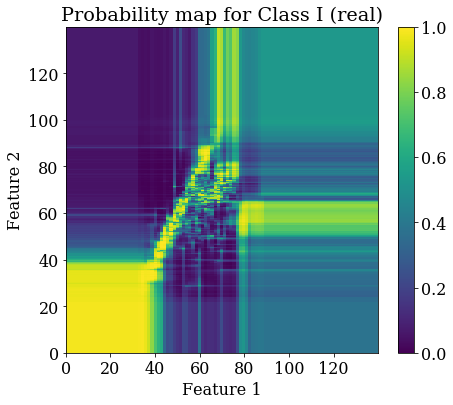

In [160]:
fig, ax = plt.subplots(1,1, figsize=(7,6))

pcmesh = ax.pcolormesh(x, y, z, cmap='viridis')
ax.set(xlabel='Feature 1', ylabel='Feature 2', 
       title='Probability map for Class I (real)',
       xticks=range(0, 140, 20),
       yticks=range(0, 140, 20),
       xlim=[0,140], ylim=[0, 140])
plt.colorbar(pcmesh, ax=ax)

# ax.scatter(X[:,0], X[:,1], alpha=0.05)
# ax.scatter(X_syn[:,0], X_syn[:,1], alpha=0.05)

## Step 3
Build the similarity matrix to describe pair-wise similarity between all the 'real' objects in the sample.

"The algorithm presented by Shi & Horvath (2006) propagates each pair of objects in the decision trees and counts how many times these objects ended up in the same terminal node (leaf). Since a leaf in the tree describes the same route inside the tree, objects that end up in the same leaf are described by the same model within the same tree and therefore are similar. The similarity measure can vary from 0 (objects never end up in the same leaf) to N_trees (objects ended up in the same leaf in all the decision trees)."

It turns out it is not optimal to count all the leafs, regardless of their prediction. Instead, the objects are propogated through the decision trees and the number of times the objects end up in the same leaf are counted while **ALSO** being predicted to both be real.

In [220]:
def build_similarity_matrix(RF, X):
    """
    This function builds the similarity matrix based on the feature 
    matrix X for the results Y based on the trained random forest.
    
    The matrix is normalized so that maximum similarity is 1 and minimum
    similarity is 0. The function also only counts leaves in which the
    object is classified as a "real" object.
    """
    # Apply the trees in the RF to X, return leaf indices
    # Matrix is len(X) by N_trees, each entry is final leaf index of X
    apply_matix = RF.apply(X)
    
    # Find the predicitions of the sample X
    # First initialize a matrix to only look at 'real' data
    is_good_matrix = np.zeros(apply_matrix.shape)
    
    # Then loop through each estimator (a decision tree)
    for i, tree in enumerate(RF.estimators_):
        # Grab only objects which are classified as real
        prediction_mask = (tree.predict_proba(X)[:,0] == 1)
        is_good_matrix[:, i] = prediction_mask
    
    # Mark leaves that make the wrong prediction as -1
    # This removes them from the distance measurement
    apply_matrix[is_good_matrix == False] = -1
    
    # Now calculate the similarity matrix
    # Count the total number of trees that each pair of objects both
    # land in the same leaf, ignoring trees that make a bad prediction
    sim_matrix = np.sum((apply_matrix[:,None] == apply_matrix[None,:]) 
                           & (apply_matrix[:,None] != -1) & 
                           (apply_matrix[None,:] != -1), axis=2) 

    # Then normalize to the size of the forest (that made good predictions)
    N_trees = np.asfarray(np.sum([apply_matrix != -1], axis=2), 
                             dtype='float')
        
    sim_matrix = sim_matrix / N_trees
        
    return sim_matrix

In [218]:
sim_matrix  = build_similarity_matrix(RF, X)
dist_matrix = 1 - sim_matrix # distance matrix

[[ 489.  459.  477. ...,  320.  427.  368.]]


## Step 4
Sum (average) the distance matrix to calculate 'weirdness score.' Objects with large distances on average from the rest will have a higher sum, and therefore a higher weirdness score.

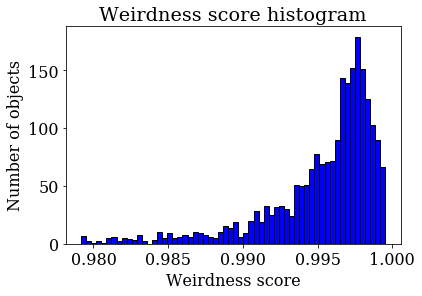

In [232]:
weirdness = np.sum(dist_matrix, axis=1)
# Normalize
weirdness /= float(len(weirdness))

fig, ax = plt.subplots(1,1, figsize=(6,4))

ax.hist(weirdness, bins=60, color='b', edgecolor='k')
ax.set(title="Weirdness score histogram",
      xlabel="Weirdness score", ylabel="Number of objects")

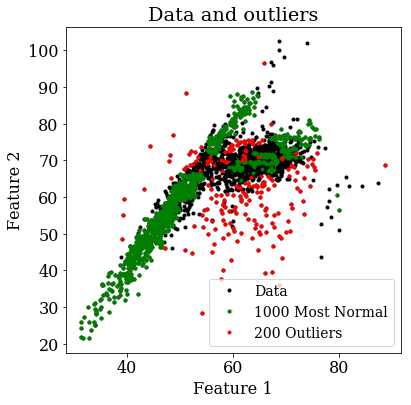

In [257]:
# Plot the 200 weirdest objects in the sample
N_outliers = 200
weird_outliers = np.sort(weirdness)[-N_outliers:]
outlier_objids = obj_ids[np.argsort(weirdness)][-N_outliers:]
normal_objids = obj_ids[np.argsort(weirdness)][:1000]

fig, ax = plt.subplots(1,1, figsize=(6,6))

ax.plot(X[:,0], X[:,1], "ok", label='Data', markersize=3)
ax.plot(X[normal_objids, 0], X[normal_objids, 1], "og", 
        label='1000 Most Normal', markersize=3)
ax.plot(X[outlier_objids, 0], X[outlier_objids, 1], "or",
           label="200 Outliers", markersize=3)
ax.set(xlabel='Feature 1', ylabel='Feature 2',
          title='Data and outliers')

ax.legend(loc='best', fontsize=14)